In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from gpytorch.kernels import RBFKernel
from grakel.kernels import WeisfeilerLehman
from gpytorch.priors import NormalPrior
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.models import GIN, GAT, GCN, GraphSAGE

from mobius import Planner, SequenceGA, Pool
from mobius import ProteinEmbedding
from mobius import InverseFolding
from mobius import GPLLModel, GPModel, GPGNNModel, GPGKModel
from mobius import ExpectedImprovement
from mobius import Graph, Map4Fingerprint
from mobius import TanimotoSimilarityKernel
from mobius import homolog_scanning
from mobius import convert_FASTA_to_HELM, convert_HELM_to_FASTA
from mobius.utils import MolFromHELM
from mobius.utils import generate_biopolymer_design_protocol_from_probabilities

## Thrombin dataset

Citation: De novo development of small cyclic peptides that are orally bioavailable; Merz et al.; 2024; https://doi.org/10.1038/s41589-023-01496-y

In [65]:
df_exp = pd.read_excel('41589_2023_1496_MOESM10_ESM.xlsx')

In [66]:
df_exp = df_exp.iloc[2:].rename(columns={'Amino acids are indicated from N- to C-terminal end. The C-terminal always contained a cysteamine. ': 'AA1',
                                         'Unnamed: 1': 'AA2', 'Unnamed: 2': 'AA3', 'Unnamed: 3': 'Linker', 'Unnamed: 4': 'Acid', 
                                         'Unnamed: 5': 'Residual thrombin activity'})

In [67]:
df_exp

,AA1,AA2,AA3,Linker,Acid,Residual thrombin acitivity
2,Cysteine,X5,X22,L2,A11,3.076003
3,3-Mercaptopropionic acid,X13,X3,L1,A11,12.960134
4,Cysteine,X8,X22,L2,A11,14.566299
5,3-Mercaptopropionic acid,X13,X1,L1,A11,16.596343
6,3-Mercaptopropionic acid,X8,X18,L3,A11,19.798256
...,...,...,...,...,...,...
8445,3-Mercaptopropionic acid,X16,X8,L1,A5,119.726506
8446,Cysteine,X1,X26,L2,A7,120.026232
8447,Cysteine,X26,X7,L2,A6,124.386999
8448,Cysteine,X26,X9,L2,A12,125.903846


In [96]:
aa_backbones = ['X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30']
aa_sidechains = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10']
di_aa = ['X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20']
linkers = {'L1': '[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|',
           'L2': '[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|',
           'L3': '[*]Cc1ccc(C[*])cc1 |$_R1;;;;;;;_R2;;$|',
           'L4': '[*]C/C=C/C[*] |$_R1;;;;;_R2$|'}
acids = ['A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14']

helms = []
mols = []

for i, peptide in df_exp.iterrows():
    if peptide['AA1'] == 'Cysteine':
        # Peptide format 1 and 2
        if peptide["Acid"] == 'No acid':
            helm = f'CHEM1{{[{linkers[peptide["Linker"]]}]}}|PEPTIDE1{{C.[{peptide["AA2"]}].[{peptide["AA3"]}].[Mea]}}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0'
        else:
            helm = f'CHEM1{{[{linkers[peptide["Linker"]]}]}}|PEPTIDE1{{[{peptide["Acid"]}].C.[{peptide["AA2"]}].[{peptide["AA3"]}].[Mea]}}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0'
    elif peptide['AA1'] == '3-Mercaptopropionic acid':
        if peptide['AA2'] in di_aa:
            # Peptide format 3
            if peptide["Acid"] == 'No acid':
                helm = f'CHEM1{{[{linkers[peptide["Linker"]]}]}}|PEPTIDE1{{[Mpa].[{peptide["AA2"]}].[{peptide["AA3"]}].[Mea]}}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0'
            else:
                helm = f'CHEM1{{[{linkers[peptide["Linker"]]}]}}|PEPTIDE1{{[Mpa].[{peptide["AA2"]}].[{peptide["AA3"]}].[Mea]}}|PEPTIDE2{{[{peptide["Acid"]}]}}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0'
        elif peptide['AA2'] in aa_sidechains:
            # Peptide format 4
            if peptide["Acid"] == 'No acid':
                helm = f'CHEM1{{[{linkers[peptide["Linker"]]}]}}|PEPTIDE1{{[Mpa].[{peptide["AA2"]}].[{peptide["AA3"]}].[Mea]}}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3$$$V2.0'
            else:
                helm = f'CHEM1{{[{linkers[peptide["Linker"]]}]}}|PEPTIDE1{{[Mpa].[{peptide["AA2"]}].[{peptide["AA3"]}].[Mea]}}|PEPTIDE2{{[{peptide["Acid"]}]}}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0'
        else:
            raise ValueError(f'Can generate HELM for this peptide {peptide} starting with Mpa.')
    else:
        raise ValueError(f'Can generate HELM for this peptide {peptide}.')

    helms.append(helm)
    mols.append(MolFromHELM(helm, HELM_extra_library_filename='library.json')[0])

df_exp['HELM'] = helms

In [114]:
df_exp.to_csv('thrombin_dataset.csv', index=False)

## Initialize Thrombin oracle

In [125]:
class ThrombinScorer:
    
    def __init__(self, sequences, values):
        if len(sequences) != len(values):
            raise ValueError(f'Different numbers of sequences and values ({len(sequences)} != {len(values)})')

        self._data = {s: v for s, v in zip(sequences, values)}

    def score(self, sequences):
        if not isinstance(sequences, (list, tuple, np.ndarray)):
            sequences = [sequences]
        
        return np.array([self._data[s] for s in sequences])

In [126]:
df_exp = pd.read_csv('thrombin_dataset.csv')
tb = ThrombinScorer(df_exp['HELM'].values, df_exp['Residual thrombin activity'].values)

## Run Bayesian Optimization

### Random search (for benchmarking purpose)

In [127]:
pool = df_exp.copy()

peptides = df_exp['HELM'][-96:].values
scores = df_exp['Residual thrombin activity'][-96:].values

data = [('random', 0, p, s) for p, s in zip(peptides, scores)]

pool = pool[~pool['HELM'].isin(peptides)]

for i in range(5):
    suggested_peptides = np.random.choice(df_exp['HELM'], size=96, replace=False)
    scores_suggested_peptides = tb.score(suggested_peptides)

    pool = pool[~pool['HELM'].isin(suggested_peptides)]

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('random', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_random.csv', index=False)

Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X5].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 40.744

Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X5].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 40.744

Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X5].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 40.744

Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X5].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 40.744

Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X5].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTID

### Graph Kernel

In [134]:
graph_convertor = Graph(input_type='HELM', output_type='grakel', HELM_extra_library_filename='library.json')
kernel = WeisfeilerLehman(normalize=True, n_iter=5)
gpmodel = GPGKModel(kernel=kernel, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

In [135]:
acq = ExpectedImprovement(gpmodel, maximize=False)
optimizer = Pool(df_exp['HELM'].values)
ps = Planner(acq, optimizer)

In [136]:
seed_library = df_exp['HELM'][-96:].values
scores_seed_library = df_exp['Residual thrombin activity'][-96:].values

In [137]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('WL', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = tb.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('WL', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_WL.csv', index=False)

Fitting GPGK model (cpu): 30step [00:05,  5.38step/s, loss=2.96]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X4].[X20].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 48.706



Fitting GPGK model (cpu): 33step [00:11,  2.83step/s, loss=3.64]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X8].[X20].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 31.925



Fitting GPGK model (cpu): 31step [00:16,  1.83step/s, loss=3.84]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X8].[X20].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 31.925



Fitting GPGK model (cpu): 22step [00:15,  1.38step/s, loss=3.91]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X1].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 16.596



Fitting GPGK model (cpu): 36step [00:34,  1.04step/s, loss=4.09]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X3].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 12.960



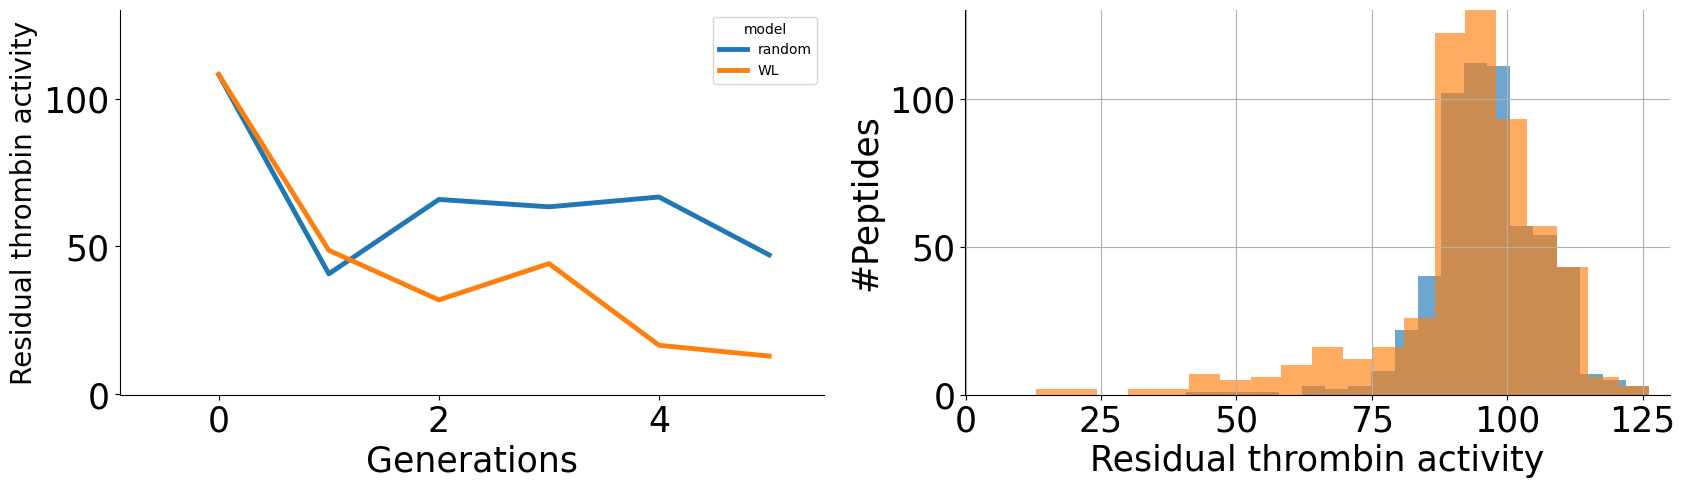

In [3]:
df_random = pd.read_csv('results_optimization_random.csv')
df_random_min = df_random.loc[df_random.groupby(by=['iter'])['exp_value'].idxmin()]

df = pd.read_csv('results_optimization_WL.csv')
df_min = df.loc[df.groupby(by=['iter'])['exp_value'].idxmin()]

df = pd.concat([df_random, df])
df_min = pd.concat([df_random_min, df_min])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df_min, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-0.1, 130])
ax[0].set_ylabel('Residual thrombin activity', fontsize=20)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'WL']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-0.1, 130])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Residual thrombin activity', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()

## MAP4 fingerprint

In [141]:
map4 = Map4Fingerprint(input_type='HELM', chiral=False, HELM_extra_library_filename='library.json')
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))

In [142]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = Pool(df_exp['HELM'].values)
ps = Planner(acq, optimizer)

In [143]:
seed_library = df_exp['HELM'][-96:].values
scores_seed_library = df_exp['Residual thrombin activity'][-96:].values

In [144]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = tb.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4.csv', index=False)

Fitting GP model (cpu): 24step [00:00, 134.86step/s, loss=2.77]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X13].[X4].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 65.276



Fitting GP model (cpu): 27step [00:00, 90.15step/s, loss=3.52]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X13].[X2].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 32.782



Fitting GP model (cpu): 24step [00:00, 58.51step/s, loss=3.56]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X3].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 12.960



Fitting GP model (cpu): 29step [00:00, 38.30step/s, loss=3.85]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X3].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 12.960



Fitting GP model (cpu): 28step [00:01, 27.71step/s, loss=3.95]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X3].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 12.960



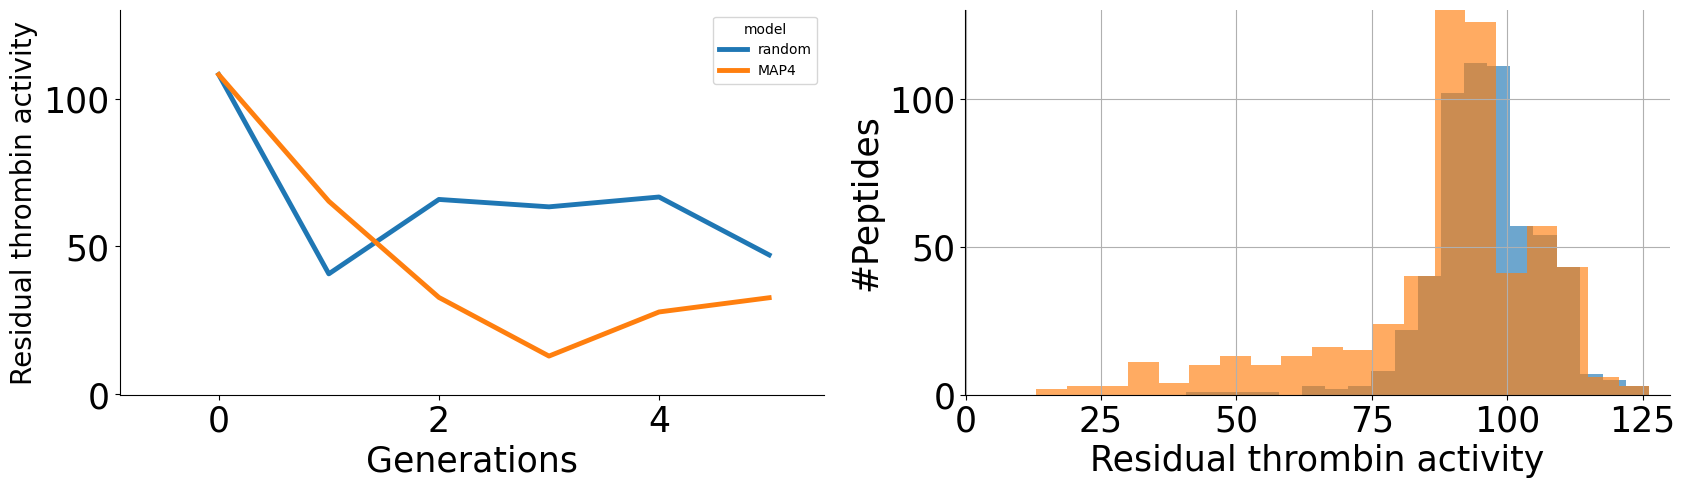

In [5]:
df_random = pd.read_csv('results_optimization_random.csv')
df_random_min = df_random.loc[df_random.groupby(by=['iter'])['exp_value'].idxmin()]

df = pd.read_csv('results_optimization_MAP4.csv')
df_min = df.loc[df.groupby(by=['iter'])['exp_value'].idxmin()]

df = pd.concat([df_random, df])
df_min = pd.concat([df_random_min, df_min])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df_min, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-0.1, 130])
ax[0].set_ylabel('Residual thrombin activity', fontsize=20)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'MAP4']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-0.1, 130])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Residual thrombin activity', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()

## MAP4 chiral fingerprint

In [146]:
map4 = Map4Fingerprint(input_type='HELM', chiral=True, HELM_extra_library_filename='library.json')
gp = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4, noise_prior=NormalPrior(loc=0, scale=1))

In [147]:
acq = ExpectedImprovement(gp, maximize=False)
optimizer = Pool(df_exp['HELM'].values)
ps = Planner(acq, optimizer)

In [148]:
seed_library = df_exp['HELM'][-96:].values
scores_seed_library = df_exp['Residual thrombin activity'][-96:].values

In [149]:
peptides = seed_library.copy()
scores = scores_seed_library.copy()

# Store data for later analysis
data = [('MAP4', 0, p, s) for p, s in zip(peptides, scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)

    # Get real permeability scores
    scores_suggested_peptides = tb.score(suggested_peptides)

    peptides = np.concatenate([peptides, suggested_peptides])
    scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
    data.extend([('MAP4C', i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])

    best_seq = peptides[np.argmin(scores)]
    best_scores = np.min(scores)
    print('Best peptide: %s / %.3f' % (best_seq, best_scores))
    print('')

df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
df.to_csv('results_optimization_MAP4C.csv', index=False)

Fitting GP model (cpu): 26step [00:00, 151.21step/s, loss=2.77]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[A11].C.[X23].[X4].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 45.526



Fitting GP model (cpu): 22step [00:00, 95.10step/s, loss=3.53]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[A11].C.[X3].[X27].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 25.195



Fitting GP model (cpu): 22step [00:00, 58.85step/s, loss=3.7] 


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[A11].C.[X3].[X27].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 25.195



Fitting GP model (cpu): 23step [00:00, 39.08step/s, loss=3.92]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[A11].C.[X3].[X27].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 25.195



Fitting GP model (cpu): 25step [00:00, 27.78step/s, loss=3.97]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X22].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 3.076



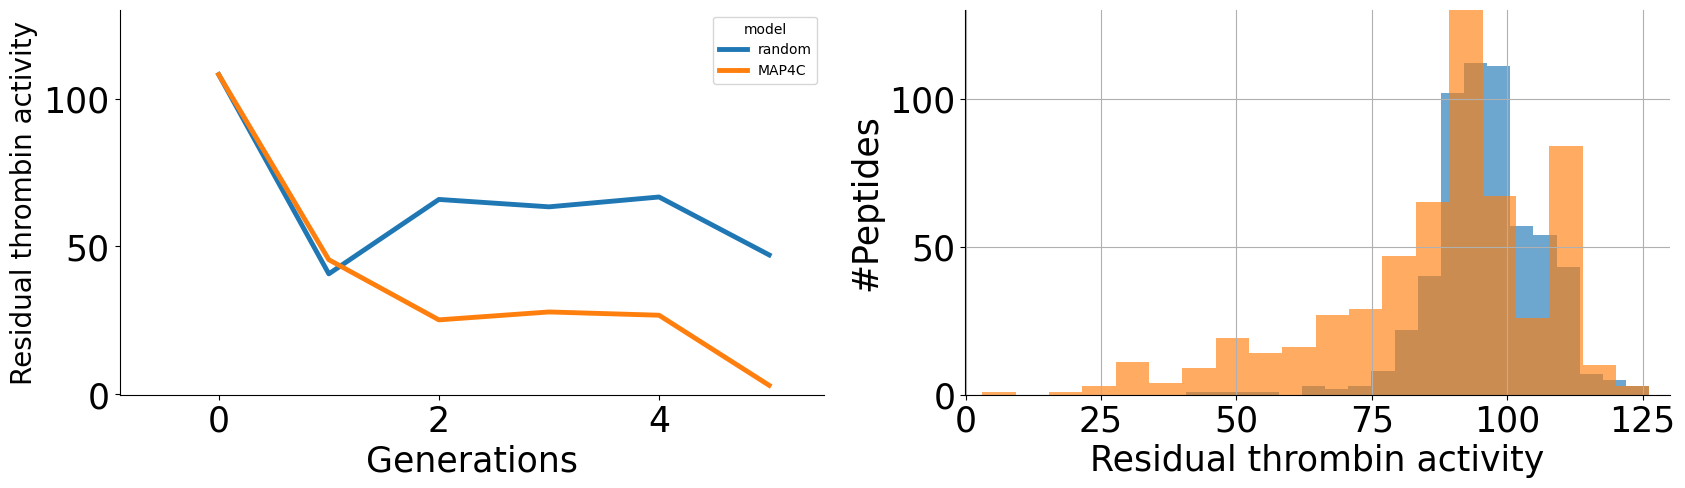

In [6]:
df_random = pd.read_csv('results_optimization_random.csv')
df_random_min = df_random.loc[df_random.groupby(by=['iter'])['exp_value'].idxmin()]

df = pd.read_csv('results_optimization_MAP4C.csv')
df_min = df.loc[df.groupby(by=['iter'])['exp_value'].idxmin()]

df = pd.concat([df_random, df])
df_min = pd.concat([df_random_min, df_min])

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df_min, ax=ax[0], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

ax[0].set_xlim([-0.9, 5.5])
ax[0].set_ylim([-0.1, 130])
ax[0].set_ylabel('Residual thrombin activity', fontsize=20)
ax[0].set_xlabel('Generations', fontsize=25)
ax[0].xaxis.set_tick_params(labelsize=25)
ax[0].yaxis.set_tick_params(labelsize=25)

df[df['model'] == 'random']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
df[df['model'] == 'MAP4C']['exp_value'].hist(ax=ax[1], density=False, alpha=0.65, bins=20)
ax[1].set_xlim([-0.1, 130])
ax[1].set_ylim([0, 130])
ax[1].set_xlabel('Residual thrombin activity', fontsize=25)
ax[1].set_ylabel('#Peptides', fontsize=25)
ax[1].xaxis.set_tick_params(labelsize=25)
ax[1].yaxis.set_tick_params(labelsize=25)
ax[1].set_title('')

sns.despine()
plt.show()

## GNN models

In [158]:
graph_convertor = Graph(input_type='HELM', output_type='pyg', HELM_extra_library_filename='library.json')
graphs = graph_convertor.transform(df_exp['HELM'].values[0])

In [159]:
class GNNModel(torch.nn.Module):
    def __init__(self, model_name, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(GNNModel, self).__init__()

        models = {'GIN': GIN, 'GAT': GAT, 'GCN': GCN, 'GraphSAGE': GraphSAGE}
        gnn_model = models[model_name]

        self.model = gnn_model(in_channels=in_channels, hidden_channels=hidden_channels, num_layers=num_layers, 
                               out_channels=out_channels, dropout=dropout)
        
        self._reset_parameters()

    def _reset_parameters(self):
        r"""Initiate parameters in the transformer model."""

        for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x):
        node_attr, edge_index, edge_attr, batch = x.node_attr, x.edge_index, x.edge_attr, x.batch
        x = self.model(x=node_attr, edge_index=edge_index, edge_attr=edge_attr, batch=batch)
        x = global_mean_pool(x, batch)

        return x

In [160]:
models = ['GAT', 'GraphSAGE', 'GCN', 'GIN']

for model in models:
    print(model)

    # define model
    gnn = GNNModel(model, in_channels=graphs.node_attr.shape[1], hidden_channels=256, out_channels=256, num_layers=4, dropout=0.25)
    gpmodel = GPGNNModel(kernel=RBFKernel(ard_num_dims=256, eps=1e-2), model=gnn, transform=graph_convertor, noise_prior=NormalPrior(loc=0, scale=1))

    # define acquisition function, optimizer and planner
    acq = ExpectedImprovement(gpmodel , maximize=True)
    optimizer = Pool(df_exp['HELM'].values)
    ps = Planner(acq, optimizer)

    # define seed library
    seed_library = df_exp['HELM'][-96:].values
    scores_seed_library = df_exp['Residual thrombin activity'][-96:].values

    peptides = seed_library.copy()
    scores = scores_seed_library.copy()
    
    # Store data for later analysis
    data = [(model, 0, p, s) for p, s in zip(peptides, scores)]
    
    for i in range(5):
        suggested_peptides, _ = ps.recommend(peptides, scores.reshape(-1, 1), batch_size=96)
    
        # Get real permeability scores
        scores_suggested_peptides = tb.score(suggested_peptides)
    
        peptides = np.concatenate([peptides, suggested_peptides])
        scores = np.concatenate((scores, scores_suggested_peptides), axis=0)
        data.extend([(model, i + 1, p, s) for p, s in zip(suggested_peptides, scores_suggested_peptides)])
    
        best_seq = peptides[np.argmin(scores)]
        best_scores = np.min(scores)
        print('Best peptide: %s / %.3f' % (best_seq, best_scores))
        print('')
    
    df = pd.DataFrame(data=data, columns=('model', 'iter', 'polymer', 'exp_value'))
    df.to_csv(f'results_optimization_{model}.csv', index=False)


GAT


Fitting GPGNN model (cpu): 25step [00:05,  4.92step/s, loss=3.76]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X14].[X1].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 61.191



Fitting GPGNN model (cpu): 14step [00:05,  2.41step/s, loss=8.16]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X14].[X1].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 61.191



Fitting GPGNN model (cpu): 19step [00:14,  1.32step/s, loss=7.01]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X13].[X3].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 41.395



Fitting GPGNN model (cpu): 24step [00:23,  1.03step/s, loss=6.34]


Best peptide: CHEM1{[[*]C/C=C/C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X18].[X10].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 33.886



Fitting GPGNN model (cpu): 14step [00:17,  1.22s/step, loss=6.07]


Best peptide: CHEM1{[[*]C/C=C/C[*] |$_R1;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X18].[X10].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 33.886

GraphSAGE


Fitting GPGNN model (cpu): 31step [00:06,  4.63step/s, loss=4.7] 


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X4].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 62.328



Fitting GPGNN model (cpu): 22step [00:08,  2.47step/s, loss=8.4] 


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[Mpa].[X13].[X5].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 39.377



Fitting GPGNN model (cpu): 13step [00:08,  1.46step/s, loss=8.74]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X1].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 16.596



Fitting GPGNN model (cpu): 17step [00:14,  1.15step/s, loss=7.38]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X1].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 16.596



Fitting GPGNN model (cpu): 21step [00:24,  1.18s/step, loss=6.35]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X13].[X1].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,2:R3-1:R2$$$V2.0 / 16.596

GCN


Fitting GPGNN model (cpu): 25step [00:03,  6.35step/s, loss=3.92]


Best peptide: CHEM1{[[*]Cc1cccc(C[*])n1 |$_R1;;;;;;;;_R2;$|]}|PEPTIDE1{[Mpa].[X4].[X18].[Mea]}|PEPTIDE2{[A11]}$CHEM1,PEPTIDE1,1:R1-1:R3|CHEM1,PEPTIDE1,1:R2-4:R3|PEPTIDE1,PEPTIDE2,3:R3-1:R2$$$V2.0 / 62.328



Fitting GPGNN model (cpu): 2step [00:01,  1.16step/s, loss=127]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X30].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 23.266



Fitting GPGNN model (cpu): 24step [00:12,  2.00step/s, loss=8.77]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X30].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 23.266



Fitting GPGNN model (cpu): 17step [00:13,  1.30step/s, loss=7.34]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X30].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 23.266



Fitting GPGNN model (cpu): 24step [00:24,  1.02s/step, loss=6.99]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X30].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 23.266

GIN


Fitting GPGNN model (cpu): 22step [00:04,  4.47step/s, loss=5.32]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A7].C.[X7].[X25].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 47.964



Fitting GPGNN model (cpu): 4step [00:02,  1.65step/s, loss=80.4]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A7].C.[X7].[X25].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 47.964



Fitting GPGNN model (cpu): 20step [00:14,  1.39step/s, loss=8.18]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X22].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 3.076



Fitting GPGNN model (cpu): 22step [00:19,  1.12step/s, loss=7.78]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X22].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 3.076



Fitting GPGNN model (cpu): 23step [00:29,  1.29s/step, loss=7.07]


Best peptide: CHEM1{[[*]CS(=O)(=O)C[*] |$_R1;;;;;;_R2$|]}|PEPTIDE1{[A11].C.[X5].[X22].[Mea]}$CHEM1,PEPTIDE1,1:R1-2:R3|CHEM1,PEPTIDE1,1:R2-5:R3$$$V2.0 / 3.076



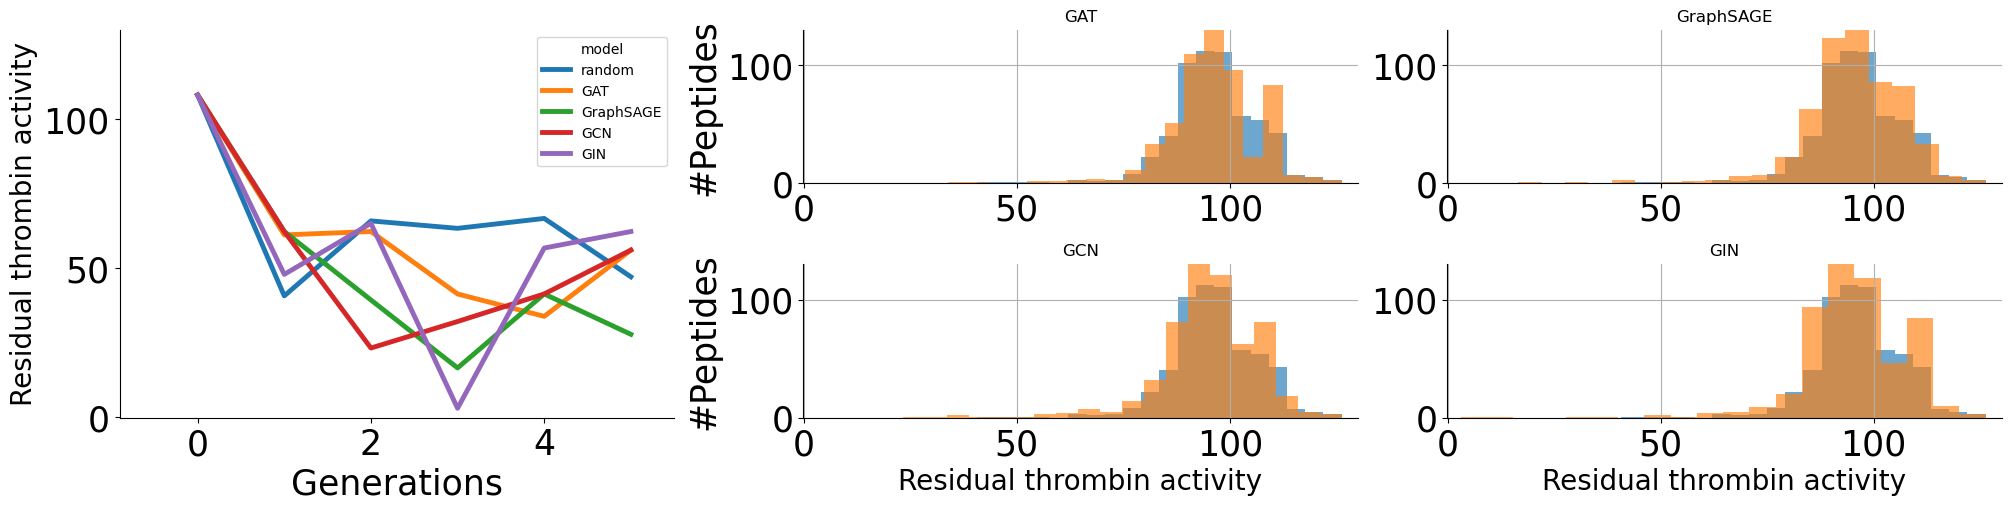

In [12]:
models = ['random', 'GAT', 'GraphSAGE', 'GCN', 'GIN']

dfs = []
dfs_min = []

for model in models:
    df = pd.read_csv(f'results_optimization_{model}.csv')
    df_min = df.loc[df.groupby(by=['iter'])['exp_value'].idxmin()]
    
    dfs.append(df)
    dfs_min.append(df_min)

df = pd.concat(dfs)
df_min = pd.concat(dfs_min)

axarr = plt.figure(figsize=(20, 5), layout="constrained").subplot_mosaic(
    """
    ABC
    ADE
    """
)

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df_min, ax=axarr['A'], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

axarr['A'].set_xlim([-0.9, 5.5])
axarr['A'].set_ylim([-0.1, 130])
axarr['A'].set_ylabel('Residual thrombin activity', fontsize=20)
axarr['A'].set_xlabel('Generations', fontsize=25)
axarr['A'].xaxis.set_tick_params(labelsize=25)
axarr['A'].yaxis.set_tick_params(labelsize=25)

models = ['GAT', 'GraphSAGE', 'GCN', 'GIN']

for ax, model in zip(['B', 'C', 'D', 'E'], models):
    df[df['model'] == 'random']['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    df[df['model'] == model]['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    axarr[ax].set_xlim([-0.1, 130])
    axarr[ax].set_ylim([0, 130])
    axarr[ax].xaxis.set_tick_params(labelsize=25)
    axarr[ax].yaxis.set_tick_params(labelsize=25)
    axarr[ax].set_title(model)

axarr['D'].set_xlabel('Residual thrombin activity', fontsize=20)
axarr['E'].set_xlabel('Residual thrombin activity', fontsize=20)
axarr['B'].set_ylabel('#Peptides', fontsize=25)
axarr['D'].set_ylabel('#Peptides', fontsize=25)

sns.despine()
plt.show()

# Results comparison

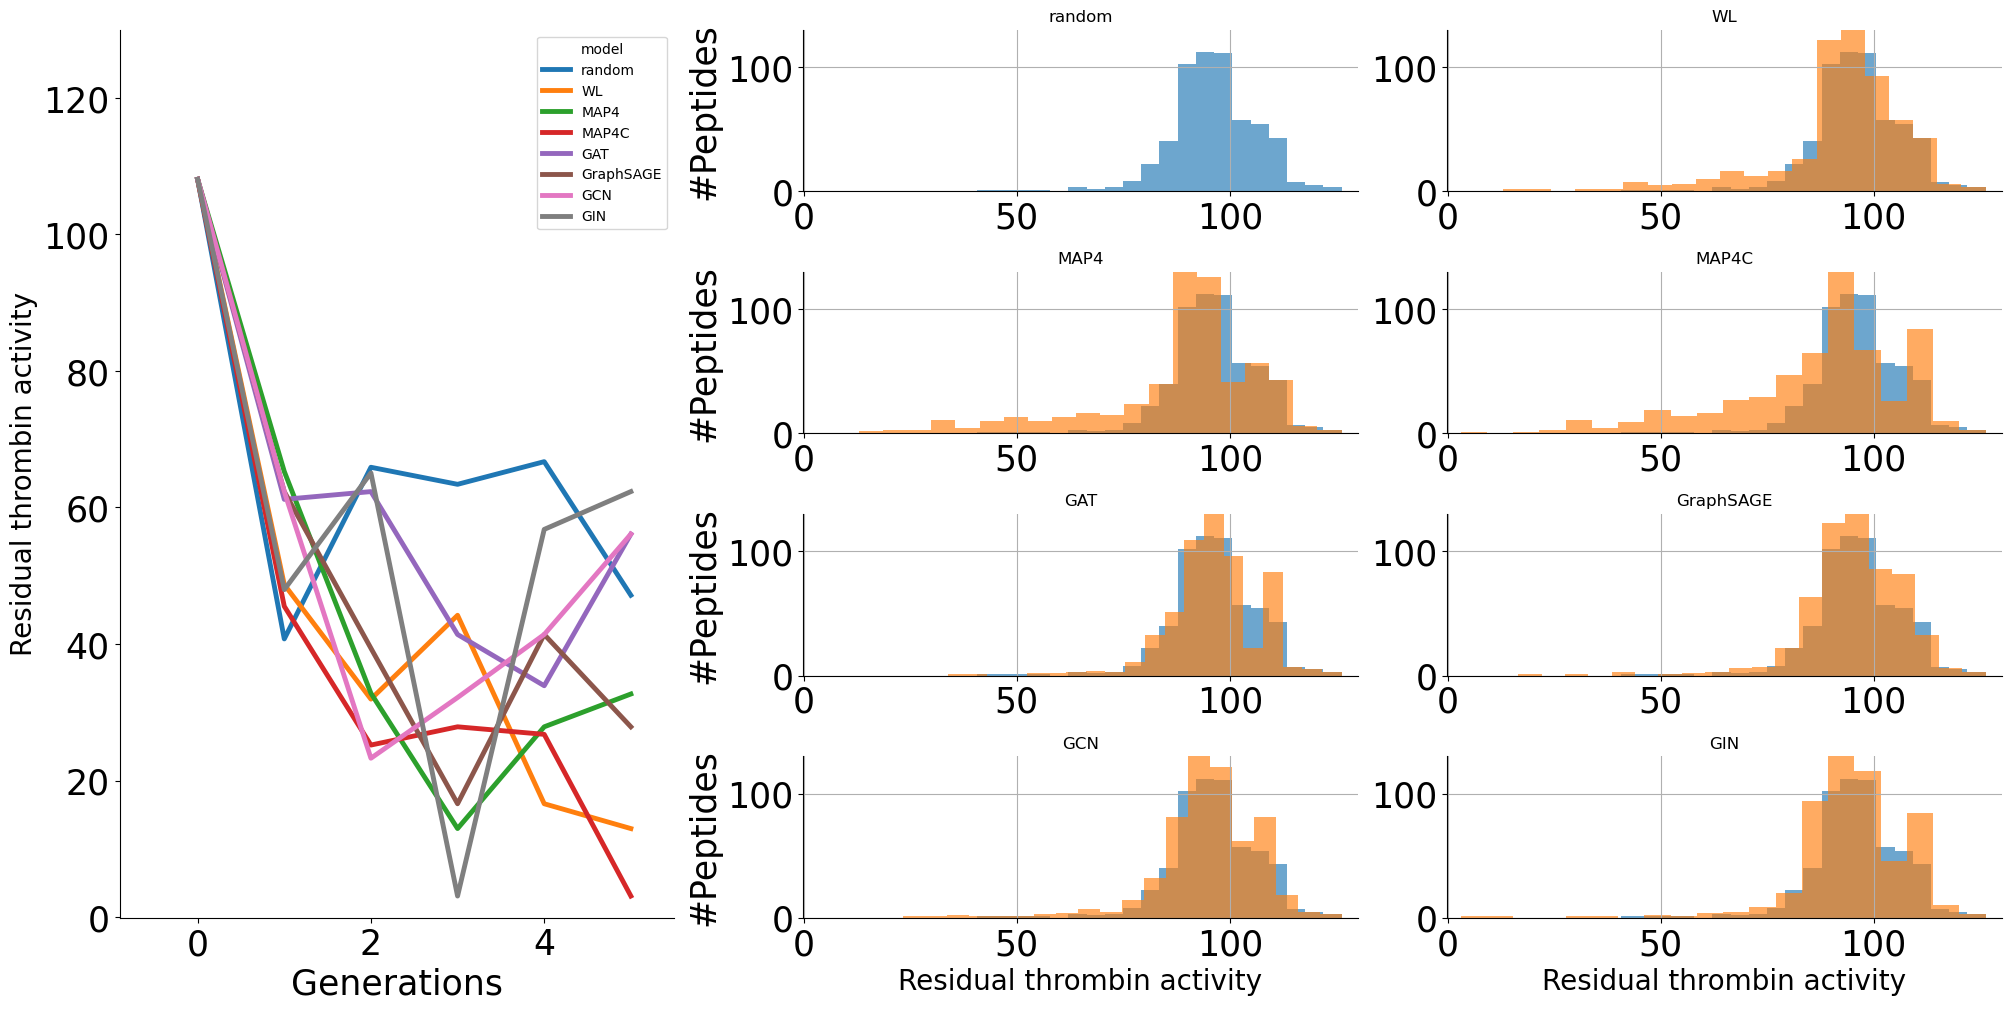

In [11]:
models = ['random', 'WL', 'MAP4', 'MAP4C', 'GAT', 'GraphSAGE', 'GCN', 'GIN']

dfs = []
dfs_min = []

for model in models:
    df = pd.read_csv(f'results_optimization_{model}.csv')
    df_min = df.loc[df.groupby(by=['iter'])['exp_value'].idxmin()]
    
    dfs.append(df)
    dfs_min.append(df_min)

df = pd.concat(dfs)
df_min = pd.concat(dfs_min)

axarr = plt.figure(figsize=(20, 10), layout="constrained").subplot_mosaic(
    """
    ABC
    ADE
    AFG
    AHI
    """
)

# pandas dataframe (df) columns: iter, peptide, exp_value
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.lineplot(x='iter', y='exp_value', hue='model', data=df_min, ax=axarr['A'], errorbar=('ci', 95), err_style='bars', linewidth=3.5, err_kws={'lw': 3.5})

axarr['A'].set_xlim([-0.9, 5.5])
axarr['A'].set_ylim([-0.1, 130])
axarr['A'].set_ylabel('Residual thrombin activity', fontsize=20)
axarr['A'].set_xlabel('Generations', fontsize=25)
axarr['A'].xaxis.set_tick_params(labelsize=25)
axarr['A'].yaxis.set_tick_params(labelsize=25)

for ax, model in zip(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], models):
    df[df['model'] == 'random']['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    if model != 'random':
        df[df['model'] == model]['exp_value'].hist(ax=axarr[ax], density=False, alpha=0.65, bins=20)
    axarr[ax].set_xlim([-0.1, 130])
    axarr[ax].set_ylim([0, 130])
    axarr[ax].xaxis.set_tick_params(labelsize=25)
    axarr[ax].yaxis.set_tick_params(labelsize=25)
    axarr[ax].set_title(model)

axarr['H'].set_xlabel('Residual thrombin activity', fontsize=20)
axarr['I'].set_xlabel('Residual thrombin activity', fontsize=20)
axarr['B'].set_ylabel('#Peptides', fontsize=25)
axarr['D'].set_ylabel('#Peptides', fontsize=25)
axarr['F'].set_ylabel('#Peptides', fontsize=25)
axarr['H'].set_ylabel('#Peptides', fontsize=25)

sns.despine()

plt.savefig('figure_results_comparison_all_models.png', dpi=300, bbox_inches='tight')

plt.show()